# <font color='violet'>Preprocessing/Encoding: Explore Options</font>

This is the final preprocessing notebook before modeling. 
- Here, I'll try out models' performances given various variable encoding strategies. 
- I might want to balance the data, to see if that would actually improve model performance.
- I might also need to explore the possibility of feature reduction; I created multiple features in the previous notebook but am not yet sure if they'll be valuable in making predictions. 

I can begin to explore various models in the process of all this. After this, I'll create pipelines to make final decisions about strategies for encoding and modeling. 

Notebook on which this one builds: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/preprocessing2_feature_engineering.ipynb

In [1]:
import pandas as pd
import numpy as np
import os
from library.sb_utils import save_file

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, svm

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import random

from IPython.display import Audio
sound_file = './alert.wav'

In [2]:
df = pd.read_csv('../data/processed/features_engineered.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174119 entries, 0 to 2174118
Data columns (total 25 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   order_id                 int64  
 1   user_id                  int64  
 2   order_by_user_sequence   int64  
 3   order_dow                int64  
 4   order_hour_of_day        int64  
 5   days_since_prior_order   float64
 6   add_to_cart_sequence     int64  
 7   reordered                int64  
 8   product_name             object 
 9   aisle_name               object 
 10  dept_name                object 
 11  prior_purchases          int64  
 12  purchased_percent_prior  float64
 13  apple                    int64  
 14  bar                      int64  
 15  cream                    int64  
 16  free                     int64  
 17  fresh                    int64  
 18  green                    int64  
 19  mix                      int64  
 20  natural                  int64  
 21  organic 

In [3]:
# order_id is redundant as a combination of user and order_by_user_sequence. Delete it. 
df = df.drop(columns='order_id')
df.columns

Index(['user_id', 'order_by_user_sequence', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'add_to_cart_sequence', 'reordered',
       'product_name', 'aisle_name', 'dept_name', 'prior_purchases',
       'purchased_percent_prior', 'apple', 'bar', 'cream', 'free', 'fresh',
       'green', 'mix', 'natural', 'organic', 'original', 'sweet', 'white'],
      dtype='object')

 <font color='violet'>Understand Baseline Evaluation Metrics</font>

In [4]:
df['reordered'].mean()

0.09045641015970148

I can judge effect of my work by comparing model scores with scores of what would happen if I just guess that a random 9% of items get reordered (since 0.090 is the average of the whole 'reordered' column in this dataset). 

In [5]:
# Make an array with 196663 1s randomly dispersed aming the rest 0s. Then use that fake array
# as predictions to see what scores I'd get without using any of the work I've done/ will do. 
ones = [1] * 196663
zeroes = [0] * 1977456
array = np.concatenate([ones, zeroes])
len(array)

2174119

In [6]:
array[0:6]

array([1, 1, 1, 1, 1, 1])

In [7]:
random.shuffle(array)
array[0:6]

array([0, 0, 0, 1, 0, 0])

In [8]:
y = df['reordered']

fake baseline RF f1 score:  0.09087627057453614
fake baseline RF kappa score:  0.0004616165948774231
fake baseline RF roc_auc score:  0.5002308082974386
fake baseline RF log_loss score:  5.680732150203873
AxesSubplot(0.125,0.11;0.62x0.77)


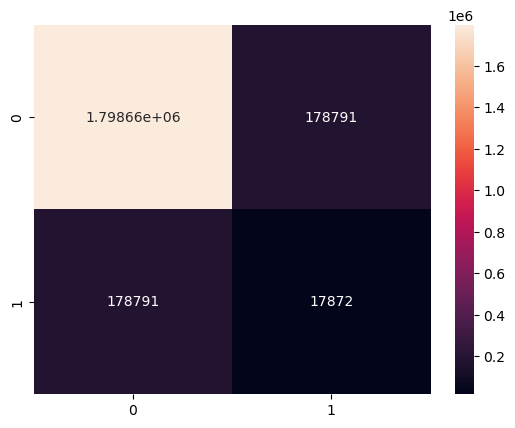

In [9]:
print('fake baseline RF f1 score: ', metrics.f1_score(y, array))
print('fake baseline RF kappa score: ', metrics.cohen_kappa_score(y, array))
print('fake baseline RF roc_auc score: ', metrics.roc_auc_score(y, array))
print('fake baseline RF log_loss score: ', metrics.log_loss(y, array))
cm = metrics.confusion_matrix(y, array)
print(sns.heatmap(cm, annot=True, fmt='g'))

My understanding is that categorical features should be encoded prior to any standardization of ordinal features. Start here. 

I'd like to try multiple encoders for categorical data. A summary of my current knowledge of encoders that could make sense for this data:
- One-Hot could work for the dept_name column because there are only 19 categories, much fewer than all the other categorical columns. It wouldn't work for any of the others. 
- Hashing works with high-cardinality variables but isn't reversible and can lead to some (usuall minimal, as far as I've read) info loss. It's not clear to me whether it involves any leakage across rows. 
- My understanding of binary encoding is that it's the best of both worlds from one-hot and hashing: fewer resultant categories than one-hot but interpretable and no info loss, unlike hashing. 
- My understanding is that Bayesian encoders generally cause contamination, so make sure to split into training and test sets prior to encoding. I read that LeaveOneOut is a Bayesian encoder that avoids leakage by not using the dependent variable.  I also read that it is especially good for classification tasks, so it's a good one to consider here.
- I know very little about WeightofEvidence but it's another Bayesian encoders recommended by Springboard and I can try it out along with Target encoder (though I'd expect Target to over-fit compared with LeaveOneOut). 

I'd like any encoder(s) I use to be included in an eventual modeling pipeline, but first I want to explore and try them out individually to see what they actually do to the data in the categorical columns. 

 <font color='violet'>Try Binary Encoder</font>

Start by just predicting the reordered column. Perhaps try predicting the add_to_cart_sequence column later. Create independent & dependent variables, encode independent categories.

In [10]:
X = df.drop(columns=['reordered', 'add_to_cart_sequence'])
y = df['reordered']

categorical_columns = ['user_id', 'product_name', 'aisle_name', 'dept_name']
ce_bin = ce.BinaryEncoder(cols=categorical_columns)
Xbin = ce_bin.fit_transform(X,y)

In [11]:
Xbin.head()

,user_id_0,user_id_1,user_id_2,user_id_3,user_id_4,user_id_5,user_id_6,user_id_7,user_id_8,user_id_9,...,cream,free,fresh,green,mix,natural,organic,original,sweet,white
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [12]:
Xbin.columns

Index(['user_id_0', 'user_id_1', 'user_id_2', 'user_id_3', 'user_id_4',
       'user_id_5', 'user_id_6', 'user_id_7', 'user_id_8', 'user_id_9',
       'user_id_10', 'user_id_11', 'order_by_user_sequence', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_name_0',
       'product_name_1', 'product_name_2', 'product_name_3', 'product_name_4',
       'product_name_5', 'product_name_6', 'product_name_7', 'product_name_8',
       'product_name_9', 'product_name_10', 'product_name_11',
       'product_name_12', 'product_name_13', 'product_name_14', 'aisle_name_0',
       'aisle_name_1', 'aisle_name_2', 'aisle_name_3', 'aisle_name_4',
       'aisle_name_5', 'aisle_name_6', 'aisle_name_7', 'dept_name_0',
       'dept_name_1', 'dept_name_2', 'dept_name_3', 'dept_name_4',
       'prior_purchases', 'purchased_percent_prior', 'apple', 'bar', 'cream',
       'free', 'fresh', 'green', 'mix', 'natural', 'organic', 'original',
       'sweet', 'white'],
      dtype='object')

In [ ]:
# Test out encoder performance in Bagging and RandomForest models. 
# These were overwhelmingly better than others when trying them out with a practice user.
# First need to standardize. Don't bother yet with tuning model hyperparameters.

Xbin_train, Xbin_test, ybin_train, ybin_test = train_test_split(Xbin, y, test_size=0.3)

scaler = StandardScaler()
Xbin_train_scaled = scaler.fit_transform(Xbin_train)
Xbin_test_scaled = scaler.transform(Xbin_test)

bgg_clf = BaggingClassifier()
bgg_clf = bgg_clf.fit(Xbin_train_scaled, ybin_train)
ybin_pred = bgg_clf.predict(Xbin_test_scaled)
print('binary bagging f1 score: ', metrics.f1_score(ybin_test, ybin_pred))
print('binary bagging kappa score: ', metrics.cohen_kappa_score(ybin_test, ybin_pred))
print('binary bagging roc_auc score: ', metrics.roc_auc_score(ybin_test, ybin_pred))
print('binary bagging log_loss score: ', metrics.log_loss(ybin_test, ybin_pred))
cm = metrics.confusion_matrix(ybin_test, ybin_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xbin_train_scaled, ybin_train)
ybin_pred = rf_clf.predict(Xbin_test_scaled)
cm = metrics.confusion_matrix(ybin_test, ybin_pred)
print('binary RF f1 score: ', metrics.f1_score(ybin_test, ybin_pred))
print('binary RF kappa score: ', metrics.cohen_kappa_score(ybin_test, ybin_pred))
print('binary RF roc_auc score: ', metrics.roc_auc_score(ybin_test, ybin_pred))
print('binary RF log_loss score: ', metrics.log_loss(ybin_test, ybin_pred))
cm = metrics.confusion_matrix(ybin_test, ybin_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

 <font color='violet'>Leave One Out Encoder</font>

In [ ]:
# Try a Bayesian encoder. Start with LeaveOneOut. Even though it has less contaminiation
# than other Bayesian encoders, it's a good idea to split data first. 

Xloo_train, Xloo_test, yloo_train, yloo_test = train_test_split(X, y, test_size=0.3)

ce_loo = ce.leave_one_out.LeaveOneOutEncoder(cols=categorical_columns, random_state=43)
ce_loo.fit(Xloo_train, yloo_train)
Xloo_train = ce_loo.transform(Xloo_train)
Xloo_test = ce_loo.transform(Xloo_test)

Xloo_train.head()

In [ ]:
print('prod min', Xloo_train['product_name'].min())
print('prod max', Xloo_train['product_name'].max())

In [ ]:
# Now try this encoded data in models after standardization

scaler = StandardScaler()
Xloo_train_scaled = scaler.fit_transform(Xloo_train)
Xloo_test_scaled = scaler.transform(Xloo_test)

bgg_clf = BaggingClassifier()
bgg_clf = bgg_clf.fit(Xloo_train_scaled, yloo_train)
yloo_pred = bgg_clf.predict(Xloo_test_scaled)
print('LeaveOneOut bagging f1 score: ', metrics.f1_score(yloo_test, yloo_pred))
print('LeaveOneOut bagging kappa score: ', metrics.cohen_kappa_score(yloo_test, yloo_pred))
print('LeaveOneOut bagging roc_auc score: ', metrics.roc_auc_score(yloo_test, yloo_pred))
print('LeaveOneOut bagging log_loss score: ', metrics.log_loss(yloo_test, yloo_pred))
cm = metrics.confusion_matrix(yloo_test, yloo_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xloo_train_scaled, yloo_train)
yloo_pred = rf_clf.predict(Xloo_test_scaled)
print('LeaveOneOut RF f1 score: ', metrics.f1_score(yloo_test, yloo_pred))
print('LeaveOneOut RF kappa score: ', metrics.cohen_kappa_score(yloo_test, yloo_pred))
print('LeaveOneOut RF roc_auc score: ', metrics.roc_auc_score(yloo_test, yloo_pred))
print('LeaveOneOut RF log_loss score: ', metrics.log_loss(yloo_test, yloo_pred))
cm = metrics.confusion_matrix(yloo_test, yloo_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

In [ ]:
# Now see whether LeaveOneOut performs better if I set drop_invariant to True.
# Stick with the random forest classifier from here on out; it's doing better than bagging.

Xloo_train, Xloo_test, yloo_train, yloo_test = train_test_split(X, y, test_size=0.3)

ce_loo = ce.leave_one_out.LeaveOneOutEncoder(cols=categorical_columns, random_state=43,
                                            drop_invariant=True)
ce_loo.fit(Xloo_train, yloo_train)
Xloo_train = ce_loo.transform(Xloo_train)
Xloo_test = ce_loo.transform(Xloo_test)

Xloo_train.head()

In [ ]:
scaler = StandardScaler()
Xloo_train_scaled = scaler.fit_transform(Xloo_train)
Xloo_test_scaled = scaler.transform(Xloo_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xloo_train_scaled, yloo_train)
yloo_pred = rf_clf.predict(Xloo_test_scaled)
print('LOO drop_invariant f1 score: ', metrics.f1_score(yloo_test, yloo_pred))
print('LOO drop_invariant kappa score: ', metrics.cohen_kappa_score(yloo_test, yloo_pred))
print('LOO drop_invariant roc_auc score: ', metrics.roc_auc_score(yloo_test, yloo_pred))
print('LOO drop_invariant log_loss score: ', metrics.log_loss(yloo_test, yloo_pred))
cm = metrics.confusion_matrix(yloo_test, yloo_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

 <font color='violet'>Target Encoder</font>
 
 Model performance dropped very slighly when I dropped columns without variance. Try some of the other Bayesian encoders. Target Encoder has hyperparameters min_sample_leaf and smoothing that I could tune if it seems worthwhile (if Target Encoder performs comparably as well as other encoders). 

In [ ]:
Xtar_train, Xtar_test, ytar_train, ytar_test = train_test_split(X, y, test_size=0.3)

ce_tar = ce.target_encoder.TargetEncoder(cols=categorical_columns)
ce_tar.fit(Xtar_train, ytar_train)
Xtar_train = ce_tar.transform(Xtar_train)
Xtar_test = ce_tar.transform(Xtar_test)

Xtar_train.head()

In [ ]:
print('prod min', Xtar_train['product_name'].min())
print('prod max', Xtar_train['product_name'].max())

In [ ]:
scaler = StandardScaler()
Xtar_train_scaled = scaler.fit_transform(Xtar_train)
Xtar_test_scaled = scaler.transform(Xtar_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xtar_train_scaled, ytar_train)
ytar_pred = rf_clf.predict(Xtar_test_scaled)
print('Target RF f1 score: ', metrics.f1_score(ytar_test, ytar_pred))
print('Target RF kappa score: ', metrics.cohen_kappa_score(ytar_test, ytar_pred))
print('Target RF roc_auc score: ', metrics.roc_auc_score(ytar_test, ytar_pred))
print('Target RF log_loss score: ', metrics.log_loss(ytar_test, ytar_pred))
cm = metrics.confusion_matrix(ytar_test, ytar_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

 <font color='violet'>Weight of Evidence Encoder</font>

#TargetEncoder seems to perform slightly better than LeaveOneOut, even on these metrics that are sensitive to over-fitting unbalanced data. Try WeightofEvidence. It does have some parameters that could be tuned but don't botherat first. 

In [ ]:
Xwoe_train, Xwoe_test, ywoe_train, ywoe_test = train_test_split(X, y, test_size=0.3)

ce_woe = ce.woe.WOEEncoder(cols=categorical_columns)
ce_woe.fit(Xwoe_train, ywoe_train)
Xwoe_train = ce_woe.transform(Xwoe_train)
Xwoe_test = ce_woe.transform(Xwoe_test)

Xwoe_train.head()

In [ ]:
print('prod min', Xwoe_train['product_name'].min())
print('prod max', Xwoe_train['product_name'].max())

In [ ]:
print('dept min', Xwoe_train['dept_name'].min())
print('dept max', Xwoe_train['dept_name'].max())

In [ ]:
print('user min', Xwoe_train['user_id'].min())
print('user max', Xwoe_train['user_id'].max())

In [ ]:
scaler = StandardScaler()
Xwoe_train_scaled = scaler.fit_transform(Xwoe_train)
Xwoe_test_scaled = scaler.transform(Xwoe_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xwoe_train_scaled, ywoe_train)
ywoe_pred = rf_clf.predict(Xwoe_test_scaled)
print('WeightofEvidence RF f1 score: ', metrics.f1_score(ywoe_test, ywoe_pred))
print('WeightofEvidence RF kappa score: ', metrics.cohen_kappa_score(ywoe_test, ywoe_pred))
print('WeightofEvidence RF roc_auc score: ', metrics.roc_auc_score(ywoe_test, ywoe_pred))
print('WeightofEvidence RF log_loss score: ', metrics.log_loss(ywoe_test, ywoe_pred))
cm = metrics.confusion_matrix(ywoe_test, ywoe_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

WeightOfEvidence performed comparably to Target Encoder, with a slightly smaller area under the curve and smaller log loss. It seems to make sense to prioritize minimizing log loss, since I want to factor in confidence in the predictions and not just how well a given model is making predictions. So for the remainer of this playing around with pre-processing options, use WOE. 

 <font color='violet'>Move forward with more hyperparameter tuning.</font>

Already decided to keep LOO's drop_invariant as default False, and that seems to be the only parameter possibly worth changing. See what happens when changing WOE's drop_invariant to true.

Then, for Target, min_samples_leaf and smoothing values seem to take values greater than 0 (int and float, respectively). I've seen examples with these set to 2 instead of the default 1. Try a few values to see what makes sense. 

In [ ]:
# Try changing drop_invariant hyperparameter for WeightofEvidence encoder. 

ce_woe = ce.woe.WOEEncoder(cols=categorical_columns, drop_invariant=True)
ce_woe.fit(Xwoe_train, ywoe_train)
Xwoe_train = ce_woe.transform(Xwoe_train)
Xwoe_test = ce_woe.transform(Xwoe_test)

scaler = StandardScaler()
Xwoe_train_scaled = scaler.fit_transform(Xwoe_train)
Xwoe_test_scaled = scaler.transform(Xwoe_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xwoe_train_scaled, ywoe_train)
ywoe_pred = rf_clf.predict(Xwoe_test_scaled)
print('WOE drop_invariant RF f1 score: ', metrics.f1_score(ywoe_test, ywoe_pred))
print('WOE drop_invariant RF kappa score: ', metrics.cohen_kappa_score(ywoe_test, ywoe_pred))
print('WOE drop_invariant RF roc_auc score: ', metrics.roc_auc_score(ywoe_test, ywoe_pred))
print('WOE drop_invariant RF log_loss score: ', metrics.log_loss(ywoe_test, ywoe_pred))
cm = metrics.confusion_matrix(ywoe_test, ywoe_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

In [ ]:
# WOE encoder performed very slightly better when dropping invariant columns.
# Move to tuning the Target Encoder's hyperparameters. 

min_samples_leaf_options = [1,2,3]
smoothing_options = [1.0,2.0,3.0]
scores = []
for leaf in min_samples_leaf_options:
    for smooth in smoothing_options:
        ce_tar = ce.target_encoder.TargetEncoder(cols=categorical_columns,
                                                min_samples_leaf=leaf,
                                                smoothing=smooth)
        ce_tar.fit(Xtar_train, ytar_train)
        Xtar_train = ce_tar.transform(Xtar_train)
        Xtar_test = ce_tar.transform(Xtar_test)
        scaler = StandardScaler()
        Xtar_train_scaled = scaler.fit_transform(Xtar_train)
        Xtar_test_scaled = scaler.transform(Xtar_test)
        rf_clf = RandomForestClassifier()
        rf_clf = rf_clf.fit(Xtar_train_scaled, ytar_train)
        ytar_pred = rf_clf.predict(Xtar_test_scaled)
        scores.append({'min_samples':leaf, 'smoothing':smooth, 
                       'log_loss': metrics.log_loss(ytar_test, ytar_pred),
                      'roc_auc': metrics.roc_auc_score(ytar_test, ytar_pred)})

compare_scores = pd.DataFrame(scores)
Audio(sound_file, autoplay=True)

In [ ]:
compare_scores.sort_values('log_loss')

# ***** Pick up here.

Previous analysis, see if it still holds true:

The range from best to worst scores is tiny, and there seems to be no pattern to variations across metrics; I could likely just stick with the default parameters if I use TargetEncoder. Compared with WeightofEvidence, 

 <font color='violet'>Try resampling to inspect its effects on model performance: over-sample, under-sample, balanced SVM</font>

In [ ]:
# Oversample first. Split into train-test sets so I'm only over-sampling the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Put training sets back together for purposes of oversampling
train_set = pd.concat([X_train, y_train], axis=1)
print(X_train.shape, train_set.shape)

In [ ]:
len(df[df['reordered']==1])

In [ ]:
# Over-sample the minority class in the training data, to quadruple its size.
over_sampled3 = train_set[train_set['reordered']==1].sample(n=589989, axis=0, replace=True, 
                                                            random_state=43)  
quadrupled_reorders = pd.concat([train_set, over_sampled3])
quadrupled_reorders.shape

In [ ]:
# Now re-split X_train and y_train, then run through encoding and modeling. 

Xo_train = quadrupled_reorders.drop(columns=['reordered'])
yo_train = quadrupled_reorders['reordered']

# Try out with WOE encoder & RandomForest
ce_woe = ce.woe.WOEEncoder(cols=categorical_columns, drop_invariant=True)
ce_woe.fit(Xo_train, yo_train)
Xo_train = ce_woe.transform(Xo_train)
X_test = ce_woe.transform(X_test)

scaler = StandardScaler()
Xo_train_scaled = scaler.fit_transform(Xo_train)
X_test_scaled = scaler.transform(X_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xo_train_scaled, yo_train)
y_pred = rf_clf.predict(X_test_scaled)

print('quadruple oversample roc_auc: ', metrics.roc_auc_score(y_test, y_pred))
print('quadruple oversample log_loss: ', metrics.log_loss(y_test, y_pred))

In [ ]:
Audio(sound_file, autoplay=True)

This modeling with over-sampled training data performed less well than the same encoder/classifier using the original data. 

Next, try a different method for dealing with unbalanced data. 

In [ ]:
# Undersample the majority class. Cut the index in half. This will leave the dataset with about 
# a 5:1 non-reorders:reorders. Rather than the original ratio of 9:1
len(train_set)

In [ ]:
index_to_drop = random.sample(train_set.index.to_list(),760942)
undersampled = train_set.drop(index_to_drop)
len(undersampled)

In [ ]:
# Again, re-split X_train and y_train, then run through encoding and modeling. 

Xu_train = undersampled.drop(columns=['reordered'])
yu_train = undersampled['reordered']

# Try out with WOE encoder & RandomForest
ce_woe = ce.woe.WOEEncoder(cols=categorical_columns, drop_invariant=True)
ce_woe.fit(Xo_train, yo_train)
Xu_train = ce_woe.transform(Xu_train)
X_test = ce_woe.transform(X_test)

scaler = StandardScaler()
Xu_train_scaled = scaler.fit_transform(Xu_train)
X_test_scaled = scaler.transform(X_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xu_train_scaled, yu_train)
y_pred = rf_clf.predict(X_test_scaled)

print('undersampled roc_auc: ', metrics.roc_auc_score(y_test, y_pred))
print('undersampled log_loss: ', metrics.log_loss(y_test, y_pred))

In [ ]:
# Undersampling is definitely a bad idea, even with the large size of the data. 
# Try using a support vector macine's class_weight parameter to balance the classes. 
# Work from the data previously encoded using WOE Encoder. 

svm_svc_clf = svm.SVC(class_weight='balanced', max_iter=1, random_state=43)
svm_svc_clf = svm_svc_clf.fit(Xwoe_train_scaled, ywoe_train)
ywoe_pred = svm_svc_clf.predict(Xwoe_test_scaled)
print('Target SVM balance f1 score: ', metrics.f1_score(ywoe_test, ywoe_pred))
print('Target SVM balance kappa score: ', metrics.cohen_kappa_score(ywoe_test, ywoe_pred))
print('Target SVM balance roc_auc score: ', metrics.roc_auc_score(ywoe_test, ywoe_pred))
print('Target SVM balance log_loss score: ', metrics.log_loss(ywoe_test, ywoe_pred))
cm = metrics.confusion_matrix(ywoe_test, ywoe_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

The SVM model, even with balancing, performed as absysmally as the last time I tried. 

It's looking like Target Encoding and a Random Forest model with unbalanced data as-is looks best so far. Run times on these models are manageable but quite long with the current-sized dataset, so keep what I've got.

 <font color='violet'>Try removing rows where department = missing, since this category of products may bring incoherence to the dept_name feature.</font>

In [ ]:
# Get new dataset with missing rows removed
missing_dept = df[df['dept_name']=='missing'].index.to_list()
df_no_missing_dept = df.drop(missing_dept)
print(len(df), len(df_no_missing_dept))

In [ ]:
# Try modeling with this dataset. 

X_no_miss = df_no_missing_dept.drop(columns=['reordered', 'add_to_cart_sequence'])
y_no_miss = df_no_missing_dept['reordered']
X_no_miss_train, X_no_miss_test, y_no_miss_train, y_no_miss_test = train_test_split(
    X_no_miss, y_no_miss, test_size=0.3)

ce_woe = ce.woe.WOEEncoder(cols=categorical_columns, drop_invariant=True)
ce_woe.fit(X_no_miss_train, y_no_miss_train)
Xwoe_train = ce_woe.transform(X_no_miss_train)
Xwoe_test = ce_woe.transform(X_no_miss_test)

scaler = StandardScaler()
X_no_miss_train_scaled = scaler.fit_transform(Xwoe_train)
X_no_miss_test_scaled = scaler.transform(Xwoe_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(X_no_miss_train_scaled, y_no_miss_train)
y_no_miss_pred = rf_clf.predict(X_no_miss_test_scaled)

print('WOE CF w/o missing dept f1 score: ', metrics.f1_score(
    y_no_miss_test, y_no_miss_pred))
print('WOE CF w/o missing dept kappa score: ', metrics.cohen_kappa_score(
    y_no_miss_test, y_no_miss_pred))
print('WOE CF w/o missing dept roc_auc score: ', metrics.roc_auc_score(
    y_no_miss_test, y_no_miss_pred))
print('WOE CF w/o missing dept log_loss score: ', metrics.log_loss(
    y_no_miss_test, y_no_miss_pred))
cm = metrics.confusion_matrix(y_no_miss_test, y_no_miss_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

Evaluation metrics from when I used the same encoder and classifer without dropping rows that had a 'missing' department name:

WOE drop_invariant RF f1 score:  0.281594725776728
WOE drop_invariant RF kappa score:  0.24992202056571944
WOE drop_invariant RF roc_auc score:  0.5857957584684185
WOE drop_invariant RF log_loss score:  2.931353355620386

The log loss is lower and the area under the curve is higher when dropping all rows involving orders of products from the 'missing' department. My hypothesis is that these items did in fact bring incoherence to the dept_name column by skewing patterns in inherent 'reorder-ability' for popular departments such as 'dairy & eggs.'

In a real-world situation, if we definitely wanted to be able to recommend those items currently in the 'missing' department, it would make more sense to reclassify items. As it is, if I keep the missing department's rows, they hinder the model's ability to correctly predict all other items' reorders. 

In [ ]:
Audio(sound_file, autoplay=True)

 <font color='violet'>PCA</font>
 
Finally, try dimensionality reduction to see if this improves performance at all. My prediction is that it may very well improve performance, since removing columns with no variance during WeightOfEvidence encoding did help slightly. 

Find intrinsic dimensions of independent variables from a training set. Use the encoded, normalized training set from the df I just created with all rows except those where the department name was missing. 

In [ ]:
pca = PCA()
pca.fit(X_no_miss_train_scaled)
features = range(pca.n_components_)

#Plot variances of PCA featuers
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

In [ ]:
pca.explained_variance_

In [ ]:
# Reduce dimensions of training set independent variables to 17 based on the plot. (Change in 
# variance plateaus at PCA feature 3, then drops again after feature 16; keep through plateau)

pca = PCA(n_components=17)
pca.fit(Xwoe_train_scaled)
X_reduced_train = pca.transform(X_no_miss_train_scaled)
X_reduced_test = pca.transform(X_no_miss_test_scaled)

# Continue with modeling
rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(X_reduced_train, y_no_miss_train)
y_reduced_pred = rf_clf.predict(X_reduced_test)
print('dimensions reduced RF f1 score: ', metrics.f1_score(ywoe_test, ywoe_pred))
print('dimensions reduced RF kappa score: ', metrics.cohen_kappa_score(ywoe_test, ywoe_pred))
print('dimensions reduced RF roc_auc score: ', metrics.roc_auc_score(ywoe_test, ywoe_pred))
print('dimensions reduced RF log_loss score: ', metrics.log_loss(ywoe_test, ywoe_pred))
cm = metrics.confusion_matrix(ywoe_test, ywoe_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

In [ ]:
Audio(sound_file, autoplay=True)

PCA wasn't helpful. I did try changing the value of n_components a couple times (i.e. 3,4), and the performance was similar to when n_components = 17. It seems that maintaining all features helps the model perform better. 

 <font color='violet'>Next Steps</font>
 
1. Save the dataset with the missing department removed for all future work.
2. I am now ready to create a pipeline with which to make final determinations about model parameters and finalize the model I'd use to predict reorders. 
3. Thinking ahead, I could try to see how well I predict not exactly whether an item will be reordered or not, but instead: If I predict the first 5 items to be reordered, will any one of them end up actually getting reordered?